## Árvores de Decisão com Índice de Gini

As árvores de decisão são algoritmos de aprendizado supervisionado amplamente utilizados para classificação e regressão. O algoritmo divide os dados em subgrupos recursivamente com base em atributos preditores, utilizando o **índice de Gini** para medir a qualidade das divisões.

### Índice de Gini

O índice de Gini mede a impureza de um conjunto de dados. Quanto menor o índice, mais homogêneo é o grupo. A fórmula é dada por:

\[
G = 1 - \sum_{k} P(C_k)^2
\]

Onde:
- \(P(C_k)\): Proporção de amostras pertencentes à classe \(C_k\) no grupo.
- \(k\): Total de classes.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from models.decision_tree.decision_tree import DecisionTreeGini
from models.utils import accuracy, f1_score, recall, precision 
from sklearn.metrics import roc_curve, auc, precision_recall_curve

## Funcão grid search

validações cruzadas em 10 folds no interior do grid-search

In [16]:
def grid_search_cv(model_class, X, y, param_grid, cv=10):
    best_params = None
    best_score = -np.inf
    best_model = None

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            scores = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                
                model = model_class()
                model.fit(X_train, y_train, max_depth=max_depth, min_samples_split=min_samples_split)
                
                predictions = model.predict(X_val)
                accuracy = np.mean(predictions == y_val)
                scores.append(accuracy)

            avg_score = np.mean(scores)
            if avg_score > best_score:

                
                best_score = avg_score
                best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
                best_model = model

    return best_params, best_score, best_model

In [17]:
data = pd.read_csv('../data/processed/breast.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [18]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [1, 2, 3, 4, 5]
}

best_params, best_score, best_model = grid_search_cv(DecisionTreeGini, X_train, y_train, param_grid)
print(f"Melhores parâmetros: {best_params}")
print(f"Melhor pontuação: {best_score:.4f}")

Melhores parâmetros: {'max_depth': 2, 'min_samples_split': 1}
Melhor pontuação: 0.9294


## resultados do melhor modelo

In [21]:
predictions = best_model.predict(X_test)

accuracy_score = accuracy(y_test, predictions)
f1 = f1_score(y_test, predictions)
recall = recall(y_test, predictions)
precision = precision(y_test, predictions)

print(f'Acurácia: {accuracy_score:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precisão: {precision:.4f}')

Acurácia: 0.9357
F1-Score: 0.9524
Recall: 0.9821
Precisão: 0.9244


## curva ROC e curva precision-recall  

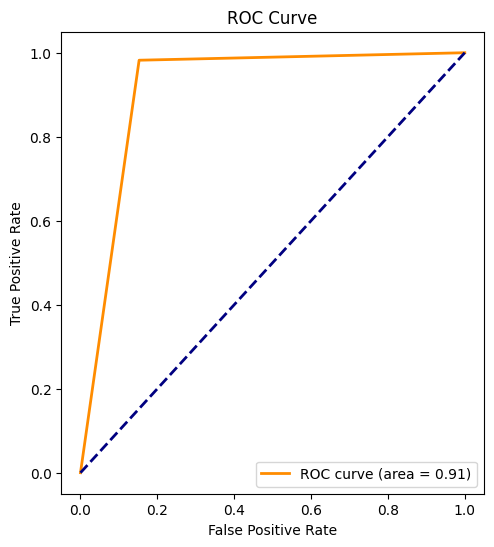

In [24]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# Subplot para ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

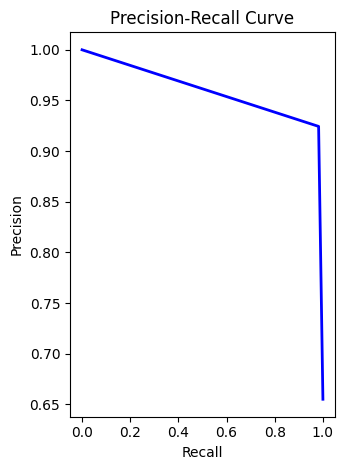

In [25]:
precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()